### As the observation of the data, the number of entrace and exits are accumulative number, we are aiming to calculate the absolute increase per each four hours in each locations

In [153]:
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
from fiona.crs import from_epsg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/amber/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Analyze for 2018 and 2019

In [116]:
mta_df = pd.read_csv('turnstile_2018_19.csv')

### calculate net_entries and net_exits for each data rows in the dataset

In [117]:
# create a unique ID for every turnstile, which combine the columns 'C/A','UNIT','SCP'
mta_df['UNIQUE_ID'] = mta_df['C/A'] + '-' + mta_df['UNIT'] + '-' + mta_df['SCP']

In [118]:
#mta_df= mta_df[['NAME', 'the_geom','UNIQUE_ID', 'LINE', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
       #'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']]

In [119]:
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,UNIQUE_ID
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2017,03:00:00,REGULAR,6463109,2187558,A002-R051-02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2017,07:00:00,REGULAR,6463119,2187567,A002-R051-02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2017,11:00:00,REGULAR,6463178,2187654,A002-R051-02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2017,15:00:00,REGULAR,6463373,2187736,A002-R051-02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2017,19:00:00,REGULAR,6463712,2187803,A002-R051-02-00-00


In [120]:
mta_df['READTIME'] = mta_df['DATE'] + ' ' + mta_df['TIME']

In [121]:
mta_df['READTIME'] = pd.to_datetime(mta_df['READTIME'], infer_datetime_format=True,errors ='coerce')

In [122]:
#Sorting data to calculate traffic for individual turnstile
mta_df.sort_values(by=['STATION', 'UNIT', 'C/A', 'SCP', 'READTIME'], inplace=True)

In [123]:
mta_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               ',
       'UNIQUE_ID', 'READTIME'],
      dtype='object')

In [124]:
mta_df = mta_df.rename(columns={'EXITS                                                               ': 'EXITS'})

In [125]:
mta_df["EXITS"] = pd.to_numeric(mta_df.EXITS, errors='coerce')

In [126]:
mta_df["ENTRIES"] = pd.to_numeric(mta_df.EXITS, errors='coerce')

In [127]:
mta_df.dtypes

C/A                  object
UNIT                 object
SCP                  object
STATION              object
LINENAME             object
DIVISION             object
DATE                 object
TIME                 object
DESC                 object
ENTRIES             float64
EXITS               float64
UNIQUE_ID            object
READTIME     datetime64[ns]
dtype: object

In [128]:
#Calculate new entries and net exits, calculate the number different between two data records
mta_df['NET_ENTRIES'] = mta_df.groupby(['STATION', 'UNIQUE_ID'])['ENTRIES'].transform(pd.Series.diff)
mta_df['NET_EXITS'] = mta_df.groupby(['STATION', 'UNIQUE_ID'])['EXITS'].transform(pd.Series.diff)

In [129]:
mta_df['NET_ENTRIES'] = mta_df['NET_ENTRIES'].fillna(1)
mta_df['NET_EXITS'] = mta_df['NET_EXITS'].fillna(1)

In [130]:
#Adding ['Day of the week' in form of an integer]
mta_df['DAY_OF_WEEK'] = mta_df['READTIME'].dt.dayofweek

mta_df.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,UNIQUE_ID,READTIME,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK
30557,H007,R248,00-00-00,1 AV,L,BMT,12/30/2017,03:00:00,REGULAR,14564385.0,14564385.0,H007-R248-00-00-00,2017-12-30 03:00:00,1.0,1.0,5.0
30558,H007,R248,00-00-00,1 AV,L,BMT,12/30/2017,07:00:00,REGULAR,14564523.0,14564523.0,H007-R248-00-00-00,2017-12-30 07:00:00,138.0,138.0,5.0
30559,H007,R248,00-00-00,1 AV,L,BMT,12/30/2017,11:00:00,REGULAR,14565009.0,14565009.0,H007-R248-00-00-00,2017-12-30 11:00:00,486.0,486.0,5.0


In [131]:
#Filtering out outliers and negative values

mta_df = mta_df[(mta_df['NET_ENTRIES'] >= 0)
                & (mta_df['NET_ENTRIES'] < 100000)
               & (mta_df['NET_EXITS'] >= 0)
                & (mta_df['NET_EXITS'] < 100000)
               & (mta_df['DAY_OF_WEEK'] < 5)]

In [132]:
mta_df.loc[mta_df['DAY_OF_WEEK'] == 0, 'label'] = 'Monday'
mta_df.loc[mta_df['DAY_OF_WEEK'] == 1, 'label'] = 'Tuesday'
mta_df.loc[mta_df['DAY_OF_WEEK'] == 2, 'label'] = 'Wednesday'
mta_df.loc[mta_df['DAY_OF_WEEK'] == 3, 'label'] = 'Thursday'
mta_df.loc[mta_df['DAY_OF_WEEK'] == 4, 'label'] = 'Friday'

In [133]:
mta_df.label.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

In [134]:
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,UNIQUE_ID,READTIME,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,label
30569,H007,R248,00-00-00,1 AV,L,BMT,01/01/2018,03:00:00,REGULAR,14570220.0,14570220.0,H007-R248-00-00-00,2018-01-01 03:00:00,429.0,429.0,0.0,Monday
30570,H007,R248,00-00-00,1 AV,L,BMT,01/01/2018,07:00:00,REGULAR,14570379.0,14570379.0,H007-R248-00-00-00,2018-01-01 07:00:00,159.0,159.0,0.0,Monday
30571,H007,R248,00-00-00,1 AV,L,BMT,01/01/2018,11:00:00,REGULAR,14570645.0,14570645.0,H007-R248-00-00-00,2018-01-01 11:00:00,266.0,266.0,0.0,Monday
30572,H007,R248,00-00-00,1 AV,L,BMT,01/01/2018,15:00:00,REGULAR,14571003.0,14571003.0,H007-R248-00-00-00,2018-01-01 15:00:00,358.0,358.0,0.0,Monday
30573,H007,R248,00-00-00,1 AV,L,BMT,01/01/2018,19:00:00,REGULAR,14571499.0,14571499.0,H007-R248-00-00-00,2018-01-01 19:00:00,496.0,496.0,0.0,Monday


## Calculate total traffic per each station

In [143]:
## calculate total traffic per each data record
mta_df['TOTAL_TRAFFIC'] = mta_df['NET_EXITS']+ mta_df['NET_ENTRIES']

In [144]:
station_data = mta_df.groupby(['STATION']).sum()

In [145]:
#The station has most traffic
station_data['STATION'] = station_data.index
station_data = station_data.sort_values(['TOTAL_TRAFFIC'],ascending=False)
station_data['Idx'] = np.arange(station_data.shape[0]) 
station_data = station_data.set_index('Idx')
station_data.head(3)

,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC,STATION
Idx,,,,,,,
0,7.952797e+12,7.952797e+12,64746438.0,64746438.0,533965.0,129492876.0,34 ST-PENN STA
1,3.356326e+12,3.356326e+12,59586879.0,59586879.0,355282.0,119173758.0,GRD CNTRL-42 ST
2,1.774708e+13,1.774708e+13,49533828.0,49533828.0,297527.0,99067656.0,34 ST-HERALD SQ


In [114]:
import seaborn as sns
sns.set_style("ticks")

##Limiting our analysis to top 15 busiest stations
station_data = station_data.iloc[:15,:]

Text(0.5, 1.0, 'Top 15 busiest stations in 2018 - 2019')

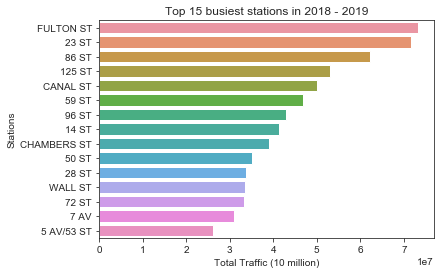

In [115]:
sns_plot = sns.barplot(x="TOTAL_TRAFFIC", y='STATION', data=station_data)
fig = sns_plot.get_figure()
plt.xlabel("Total Traffic (10 million)")
plt.ylabel("Stations")
plt.title("Top 15 busiest stations in 2018 - 2019")

# Check the tracffic changes per week for top few stations

In [75]:
#Sorting data to find the 'Total_Traffic at each station by 'day of the week'. 

mta_df_1=mta_df.groupby(['STATION','label']).sum()
mta_df_1.reset_index(inplace=True)

mta_df_1.head()

,STATION,label,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC
0,1 AV,Friday,8.606177e+11,8.606177e+11,2047589.0,2047589.0,21888.0,4095178.0
1,1 AV,Monday,8.565933e+11,8.565933e+11,1715609.0,1715609.0,0.0,3431218.0
2,1 AV,Thursday,8.583214e+11,8.583214e+11,1964671.0,1964671.0,16347.0,3929342.0
3,1 AV,Tuesday,8.634148e+11,8.634148e+11,1893769.0,1893769.0,5469.0,3787538.0
4,1 AV,Wednesday,8.519723e+11,8.519723e+11,1954927.0,1954927.0,10834.0,3909854.0


In [76]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

In [77]:
penn_data = mta_df_1[mta_df_1['STATION'] =='34 ST-PENN STA'] 

In [78]:
penn_data 

,STATION,label,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC
305,34 ST-PENN STA,Friday,1.606144e+12,1.606144e+12,13425405.0,13425405.0,213316.0,26850810.0
306,34 ST-PENN STA,Monday,1.590376e+12,1.590376e+12,11752017.0,11752017.0,0.0,23504034.0
307,34 ST-PENN STA,Thursday,1.589665e+12,1.589665e+12,13368295.0,13368295.0,161010.0,26736590.0
308,34 ST-PENN STA,Tuesday,1.577273e+12,1.577273e+12,13012468.0,13012468.0,52987.0,26024936.0
309,34 ST-PENN STA,Wednesday,1.589341e+12,1.589341e+12,13188253.0,13188253.0,106652.0,26376506.0


In [79]:
penn_data_df = penn_data.set_index('label').reindex(cats).reset_index()
penn_data_df

,label,STATION,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC
0,Monday,34 ST-PENN STA,1.590376e+12,1.590376e+12,11752017.0,11752017.0,0.0,23504034.0
1,Tuesday,34 ST-PENN STA,1.577273e+12,1.577273e+12,13012468.0,13012468.0,52987.0,26024936.0
2,Wednesday,34 ST-PENN STA,1.589341e+12,1.589341e+12,13188253.0,13188253.0,106652.0,26376506.0
3,Thursday,34 ST-PENN STA,1.589665e+12,1.589665e+12,13368295.0,13368295.0,161010.0,26736590.0
4,Friday,34 ST-PENN STA,1.606144e+12,1.606144e+12,13425405.0,13425405.0,213316.0,26850810.0


Text(0, 0.5, 'Total Traffic')

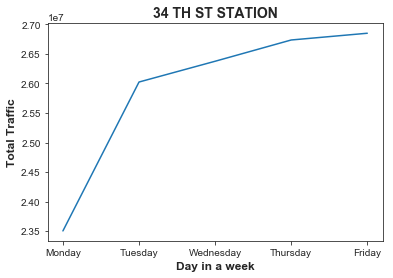

In [80]:
penn_data_df.head()
y = penn_data_df['TOTAL_TRAFFIC']
x = penn_data_df['label']

plt.plot(x,y)
plt.title("34 TH ST STATION",fontsize=14,weight='bold')
plt.xlabel('Day in a week', fontsize=12, weight='bold')
plt.ylabel('Total Traffic', fontsize=12,weight='bold')

In [81]:
grand_central_data = mta_df_1[mta_df_1['STATION'] =='GRD CNTRL-42 ST'] 
grand_central_data_df  = grand_central_data.set_index('label').reindex(cats).reset_index()
grand_central_data_df

,label,STATION,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC
0,Monday,GRD CNTRL-42 ST,6.772785e+11,6.772785e+11,10951322.0,10951322.0,0.0,21902644.0
1,Tuesday,GRD CNTRL-42 ST,6.835254e+11,6.835254e+11,12226900.0,12226900.0,35660.0,24453800.0
2,Wednesday,GRD CNTRL-42 ST,6.649845e+11,6.649845e+11,12310655.0,12310655.0,71044.0,24621310.0
3,Thursday,GRD CNTRL-42 ST,6.596262e+11,6.596262e+11,12381970.0,12381970.0,105510.0,24763940.0
4,Friday,GRD CNTRL-42 ST,6.709116e+11,6.709116e+11,11716032.0,11716032.0,143068.0,23432064.0


Text(0, 0.5, 'Total Traffic')

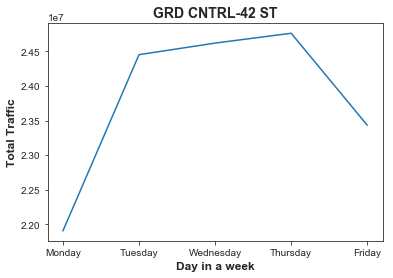

In [82]:

y = grand_central_data_df['TOTAL_TRAFFIC']
x = grand_central_data_df['label']

plt.plot(x,y)

plt.title("GRD CNTRL-42 ST",fontsize=14,weight='bold')
plt.xlabel('Day in a week', fontsize=12,weight='bold')
plt.ylabel('Total Traffic', fontsize=12,weight='bold')


In [88]:
HERALD_SQ_data= mta_df_1[mta_df_1['STATION'] =='34 ST-HERALD SQ'] 
HERALD_SQ_data_df  = HERALD_SQ_data.set_index('label').reindex(cats).reset_index()
HERALD_SQ_data_df

,label,STATION,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC
0,Monday,34 ST-HERALD SQ,3.498806e+12,3.498806e+12,8998984.0,8998984.0,0.0,17997968.0
1,Tuesday,34 ST-HERALD SQ,3.567650e+12,3.567650e+12,10032683.0,10032683.0,29891.0,20065366.0
2,Wednesday,34 ST-HERALD SQ,3.533349e+12,3.533349e+12,10084246.0,10084246.0,59150.0,20168492.0
3,Thursday,34 ST-HERALD SQ,3.579659e+12,3.579659e+12,10190326.0,10190326.0,89250.0,20380652.0
4,Friday,34 ST-HERALD SQ,3.567620e+12,3.567620e+12,10227589.0,10227589.0,119236.0,20455178.0


Text(0, 0.5, 'Total Traffic')

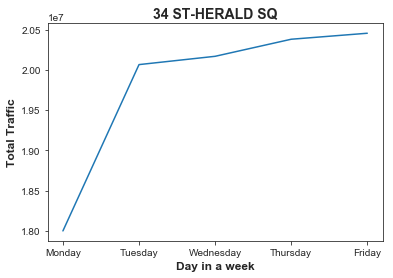

In [89]:
y =HERALD_SQ_data_df['TOTAL_TRAFFIC']
x =HERALD_SQ_data_df['label']

plt.plot(x,y)

plt.title("34 ST-HERALD SQ",fontsize=14,weight='bold')
plt.xlabel('Day in a week', fontsize=12,weight='bold')
plt.ylabel('Total Traffic', fontsize=12,weight='bold')



In [91]:
TIMES_SQ_data= mta_df_1[mta_df_1['STATION'] =='TIMES SQ-42 ST'] 
TIMES_SQ_data_df  = TIMES_SQ_data.set_index('label').reindex(cats).reset_index()
TIMES_SQ_data_df

,label,STATION,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC
0,Monday,TIMES SQ-42 ST,2.481618e+12,2.481618e+12,7344797.0,7344797.0,0.0,14689594.0
1,Tuesday,TIMES SQ-42 ST,2.469768e+12,2.469768e+12,8211194.0,8211194.0,27201.0,16422388.0
2,Wednesday,TIMES SQ-42 ST,2.491713e+12,2.491713e+12,8412834.0,8412834.0,54886.0,16825668.0
3,Thursday,TIMES SQ-42 ST,2.499383e+12,2.499383e+12,8405383.0,8405383.0,83082.0,16810766.0
4,Friday,TIMES SQ-42 ST,2.502080e+12,2.502080e+12,8312903.0,8312903.0,110060.0,16625806.0


Text(0, 0.5, 'Total Traffic')

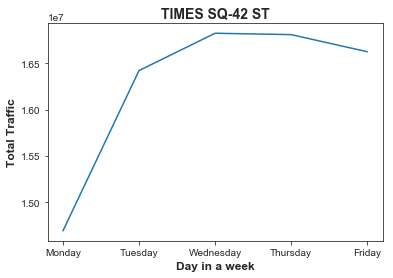

In [92]:
y =TIMES_SQ_data_df['TOTAL_TRAFFIC']
x =TIMES_SQ_data_df['label']

plt.plot(x,y)

plt.title("TIMES SQ-42 ST",fontsize=14,weight='bold')
plt.xlabel('Day in a week', fontsize=12,weight='bold')
plt.ylabel('Total Traffic', fontsize=12,weight='bold')



## Conduct spatial join and visulize the top stations in map

### Conduct Spatial Join

In [137]:
url="http://web.mta.info/developers/data/nyct/subway/Stations.csv"
s=requests.get(url).content
mta_geo=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [138]:
mta_geo= mta_geo[['Line','Stop Name', 'Borough', 'GTFS Latitude','GTFS Longitude']]

In [139]:
mta_geo.rename(columns = {'Stop Name':'NAME','GTFS Latitude':'LATITUDE','GTFS Longitude':'LONGITUDE'}, inplace = True)

In [140]:
mta_geo = mta_geo.apply(lambda x : x.astype(str).str.upper())

In [150]:
df_cor_mta = mta_geo.merge(station_data, left_on = 'NAME', right_on ='STATION')

In [151]:
df_cor_mta.head()

,Line,NAME,Borough,LATITUDE,LONGITUDE,ENTRIES,EXITS,NET_ENTRIES,NET_EXITS,DAY_OF_WEEK,TOTAL_TRAFFIC,STATION
0,ASTORIA,ASTORIA BLVD,Q,40.770258,-73.917843,5.970999e+10,5.970999e+10,3131207.0,3131207.0,26917.0,6262414.0,ASTORIA BLVD
1,ASTORIA,30 AV,Q,40.766779,-73.921479,8.043834e+10,8.043834e+10,4225791.0,4225791.0,27767.0,8451582.0,30 AV
2,ASTORIA,BROADWAY,Q,40.76182,-73.925508,9.016265e+10,9.016265e+10,4481303.0,4481303.0,40307.0,8962606.0,BROADWAY
3,CROSSTOWN,BROADWAY,BK,40.706092,-73.95030799999999,9.016265e+10,9.016265e+10,4481303.0,4481303.0,40307.0,8962606.0,BROADWAY
4,ASTORIA,36 AV,Q,40.756803999999995,-73.929575,6.194835e+10,6.194835e+10,2536383.0,2536383.0,23380.0,5072766.0,36 AV



## download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [159]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")


('file.gz', <http.client.HTTPMessage at 0x1db253d208>)

In [158]:
unzip -d $file.gz

SyntaxError: invalid syntax (<ipython-input-158-8803d972e384>, line 1)

In [ ]:
mta_df[['year','month','day']] = mta_df.READTIME.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))

In [ ]:
# Create three columns with year, months, and day
mta_df['day'] = mta_df['DATE'].mta_df.day
mta_df['month'] = mta_df.DATE.month
mta_df['year'] = mta_df.DATE.year

In [ ]:
df['day'] = df['datetime_utc'].dt.day
df['month'] = df['datetime_utc'].dt.month
df['year'] = df['datetime_utc'].dt.year

In [ ]:
mta_df.head()

In [ ]:
net = ['NET_EXITS', 'NET_ENTRIES']

In [ ]:
#set all negative hourly entries to absolute value
for item in net:
    mta_df.loc[mta_df[item] < 0, item] = abs(mta_df[item])
    mta_df[mta_df[item] < 0]

In [ ]:
#test_turn = random.randint(0,len(ids))

#test_id_df = nyc_turnstile_2017[nyc_turnstile_2017['id'] == ids[test_turn]]

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(mta_df['READTIME'],mta_df.NET_ENTRIES)
plt.plot(mta_df['READTIME'],mta_df.NET_EXITS)
#plt.set_xlabel('Date Time')
#plt.set_ylabel('Exits')
plt.legend(['Entries','Exits'])
plt.xlabel('Date and Time')
plt.ylabel('Count')
plt.title(ids[test_turn])